# Análise de votações na câmara dos deputados do Brasil
## Votações entre 1991 e 1994

Este é um trabalho para a classe Fundamentos da Matemática para Computação, UFABC, Professor Ronaldo.

Notas:
- Script utiliza como referência o script de análise de votação dos senadores;
- Os nomes dos deputados foram retirados para uma melhor visualização;
- Deputados com todos os dados de votos zerados foram removidos;
- As planilhas de dados são unidas pelos campos nome, partido e uf. Assim sendo, como os deputados podem trocar de partido durante o seu mandato, para fins de análise estes deputados constaram mais de uma vez na planilha final.

Importo as bibliotecas utilizadas para o processamento do script

In [1]:
import pandas as pd #dataframe lib
import matplotlib.pyplot as plt #plot lib
import glob # encontrar pathnames
import unicodedata # unicode parser
import numpy as np # processamento numérico
from numpy.linalg import svd
from collections import Counter
from scipy.spatial.distance import pdist,squareform # cálculo de distâncias


Esta linha é utilizada pelo Jupyter Notebook para formatar os gráficos gerados pelo matplotlib

In [2]:
%matplotlib inline

Carrega todos os dados da pasta "dados_camara" e mesclo tudo em um únido dataframe, dando um join nos dados pelas colunas: nome, partido e uf

In [3]:
votacoes = None
matchColumns = ["nome","partido","uf"]
files = ['./dados_camara/'+str(ano)+'.csv' for ano in (1991,1995)]
#files = glob.glob('./dados_camara/*.csv')
for _file in files:
    aux = pd.read_csv(_file, encoding='utf-8')
    votacoes = aux if votacoes is None \
    else pd.merge(left=votacoes, right=aux, how="outer", left_on=matchColumns, right_on=matchColumns)

Preencho os valores nulos com zeros

In [4]:
votacoes.fillna(0, inplace=True)

In [5]:
votacoes.head()

nome partido  uf  PDC 124/1991  PDC 369/1990  PDC 370/1990  \
0       Félix Mendonça     PTB  BA           0.0           1.0           1.0   
1   Geddel Vieira Lima    PMDB  BA           0.0           1.0           1.0   
2       Jairo Carneiro     PFL  BA           1.0           0.0           1.0   
3        Aroldo Cedraz     PFL  BA           0.0           0.0           0.0   
4  José Carlos Aleluia     PFL  BA           0.0           1.0           1.0   

   PDC 374/1990  PDC 63/1991  PDC 66/1991  PDC 66/1991.1      ...       \
0           1.0          0.0         -1.0           -1.0      ...        
1           0.0          0.0         -1.0           -1.0      ...        
2           0.0          0.0         -1.0           -1.0      ...        
3           0.0          1.0         -1.0           -1.0      ...        
4           1.0          0.0         -1.0           -1.0      ...        

   PL 869/1995  PL 869/1995.1  PL 899/1995  PL 899/1995.1  PL 914/1995  \
0          1.0            0.0          1.0           -1.0          1.0   
1          1.0           -1.0         -1.0            0.0          1.0   
2          1.0           -1.0          1.0            0.0          0.0   
3          1.0           -1.0          1.0            0.0          1.0   
4          1.0           -1.0          1.0           -1.0          1.0   

   PL 992/1995  PLP 9/1995  PRC 1/1995  PRC 21/1995  PRC 229/1994  
0          1.0         1.0         1.0          1.0           1.0  
1          1.0         0.0         1.0          1.0           1.0  
2          0.0         1.0         0.0          1.0           0.0  
3         -1.0         1.0         1.0          1.0           0.0  
4          1.0         1.0         1.0          1.0           0.0  

[5 rows x 158 columns]

Seleciono os votos que não tem series zeradas e seleciono as votacões com base nestes votos filtrados

In [6]:
votos = votacoes.iloc[:,3:votacoes.shape[1]]
votos = votos[(votos.T != 0).any()].reset_index(drop=True)
votacoes = votacoes.iloc[votos.index.tolist(),:].reset_index(drop=True)

Seleciono os estados e converto o formato para unicode

In [7]:
estados = votacoes.uf
estados = pd.Series([unicodedata.normalize("NFKD", e).strip() for e in estados])

Separado os estados por regiões

In [8]:
estados_regioes = {('SP','MG','RJ','ES') : 'SE' ,
           ('DF','MT','MS','GO') : 'CO' ,
           ('RS','PR','SC') : 'SU' ,
           ('AL','BA','CE','MA','PB','PE','PI','RN','SE') : 'NE',
           ('AC','AP','AM','PA','RO','RR','TO') : 'NO'}

In [9]:
regioes = pd.Series([estados_regioes[k] for e in estados for k in estados_regioes.keys()  if e in k])

Seleciono deputados e partidos

In [10]:
votacoes.shape

(1213, 158)

In [11]:
deputados = votacoes.nome

In [12]:
partidos = votacoes.partido

In [13]:
print(votacoes.shape)
votacoes.sort_values(['nome', 'partido', 'uf'])

(1213, 158)


nome  partido  uf  PDC 124/1991  PDC 369/1990  \
601           Abelardo Lupion      PFL  PR           0.0           0.0   
34             Adauto Pereira      PFL  PB           1.0           0.0   
318             Adelaide Neri     PMDB  AC           0.0           1.0   
1087          Adelson Ribeiro     PMDB  SE           0.0           0.0   
773           Adelson Ribeiro     PSDB  SE           0.0           0.0   
929          Adelson Salvador      PSB  ES           0.0           0.0   
841   Adhemar de Barros Filho      PPB  SP           0.0           0.0   
1091  Adhemar de Barros Filho      PRP  SP           0.0           0.0   
137           Adroaldo Streck     PSDB  RS           0.0          -1.0   
252             Adylson Motta      PDS  RS           1.0          -1.0   
810             Adylson Motta      PPB  RS           0.0           0.0   
891             Adylson Motta      PPR  RS           0.0           0.0   
31                Adão Pretto       PT  RS           1.0           0.0   
753           Affonso Camargo      PFL  PR           0.0           0.0   
1097          Affonso Camargo  S.Part.  PR           0.0           0.0   
1174          Agnaldo Timóteo      PPB  RJ           0.0           0.0   
983           Agnaldo Timóteo      PPR  RJ           0.0           0.0   
681            Agnelo Queiroz    PCdoB  DF           0.0           0.0   
189         Agostinho Valente       PT  MG           1.0          -1.0   
686               Airton Dipp      PDT  RS           0.0           0.0   
142              Alacid Nunes      PFL  PA          -1.0           1.0   
375           Alberto Goldman     PMDB  SP           0.0           0.0   
879            Alberto Haddad       PP  SP           0.0           0.0   
450            Alberto Haddad      PTB  SP           0.0           1.0   
525            Alberto Haddad      PTR  SP           0.0           0.0   
732             Alberto Silva     PMDB  PI           0.0           0.0   
766         Albérico Cordeiro      PTB  AL           0.0           0.0   
688            Albérico Filho     PMDB  MA           0.0           0.0   
610           Alceste Almeida     PMDB  RR           0.0           0.0   
1052          Alceste Almeida      PPB  RR           0.0           0.0   
...                       ...      ...  ..           ...           ...   
1075         Welson Gasparini     PSDB  SP           0.0           0.0   
66            Werner Wanderer      PFL  PR           0.0           0.0   
946          Wigberto Tartuce       PP  DF           0.0           0.0   
719          Wigberto Tartuce      PPB  DF           0.0           0.0   
527              Wilmar Peres       PL  MT           0.0           0.0   
459              Wilmar Peres      PSC  MT           0.0           1.0   
904              Wilson Braga      PDT  PB           0.0           0.0   
978             Wilson Branco     PMDB  RS           0.0           0.0   
172             Wilson Campos     PMDB  PE           1.0           1.0   
765             Wilson Campos     PSDB  PE           0.0           0.0   
699           Wilson Cignachi     PMDB  RS           0.0           0.0   
911              Wilson Cunha      PFL  SE           0.0           0.0   
1206             Wilson Cunha     PMDB  SE           0.0           0.0   
338              Wilson Cunha      PTB  MG           0.0          -1.0   
246            Wilson Moreira     PSDB  PR           1.0          -1.0   
262             Wilson Muller      PDT  RS           1.0           0.0   
698            Wolney Queiroz      PDT  PE           0.0           0.0   
614              Yeda Crusius     PSDB  RS           0.0           0.0   
109             Zaire Rezende     PMDB  MG           1.0           1.0   
381              Zila Bezerra     PMDB  AC           0.0           1.0   
863              Zuca Moreira     PMDB  PB           0.0           0.0   
646              Zulaiê Cobra     PSDB  SP           0.0           0.0   
986                Zé Gerardo

In [14]:
votacoes.shape

(1213, 158)

Calculo a matriz de correspondência

In [15]:
corr = np.corrcoef(votos)

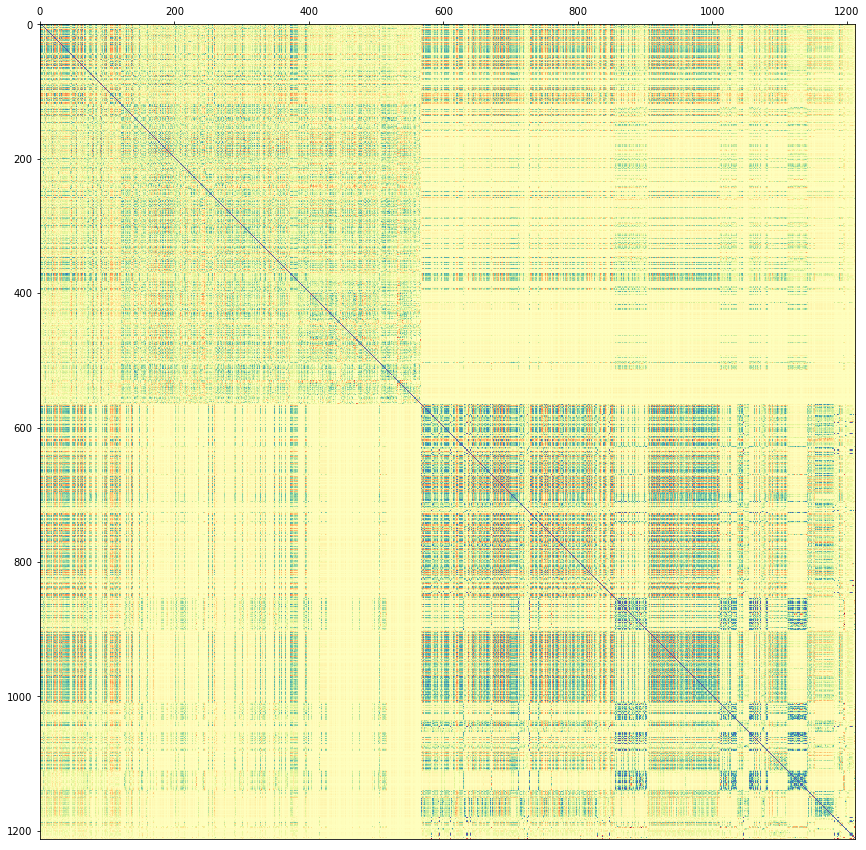

In [16]:
fig,ax = plt.subplots(figsize=(20,15))
ax.imshow(corr,cmap=plt.get_cmap('Spectral'))
#ax.set_yticks(range(len(deputados)))
#ax.set_yticklabels(deputados)
#ax.set_xticks(range(len(deputados)))
#ax.set_xticklabels(deputados,rotation=90)
ax.xaxis.tick_top()
plt.show()

## Análise de afinidade

In [17]:
U, Sigma, V = svd(corr)

In [18]:
afinidade = U[:,0]

In [19]:
cut =  np.sum(afinidade < np.mean(afinidade)) - 0.5

In [20]:
iafinidade = np.argsort(afinidade)
corr_afinidade = corr[iafinidade,:]
corr_afinidade = corr_afinidade[:,iafinidade]

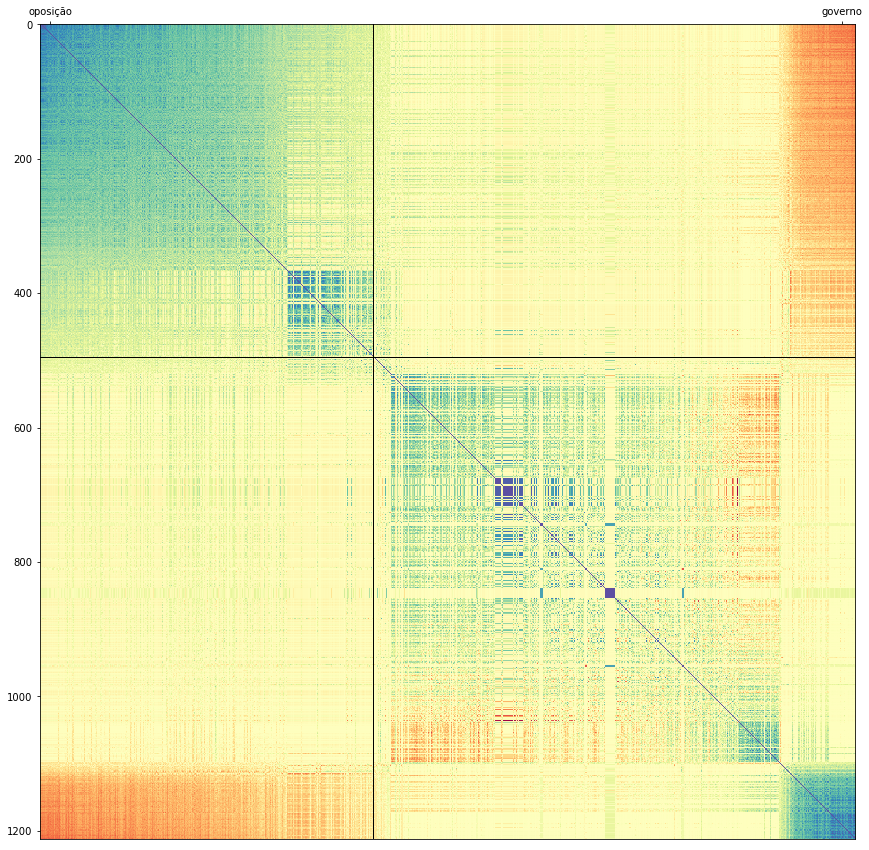

In [21]:
fig,ax = plt.subplots(figsize=(20,15))
ax.imshow(corr_afinidade,cmap=plt.get_cmap('Spectral'))
ax.plot([0,deputados.shape[0]-1],[cut,cut],color='black',lw=1)
ax.plot([cut,cut],[0,deputados.shape[0]-1],color='black',lw=1)
ax.set_xticks([15,deputados.shape[0]-20])
#ax.set_yticks(range(len(deputados)))
ax.set_xticklabels([u"oposição",u"governo"])
#ax.set_yticklabels(deputados[iafinidade])
ax.xaxis.tick_top()
plt.show()

In [22]:
part_ord = np.lexsort([iafinidade,partidos])
corr_partido = corr[part_ord,:]
corr_partido = corr_partido[:,part_ord]

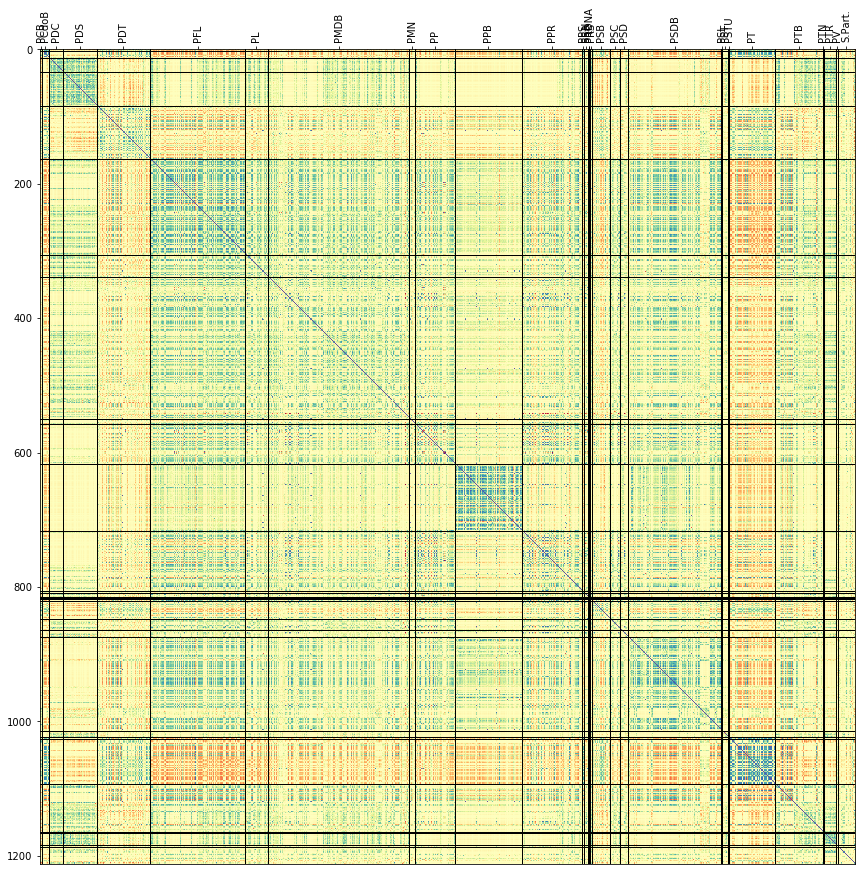

In [23]:
splits = [i for i in range(len(partidos)-1) if partidos.iloc[i] != partidos.iloc[i+1]]
fig,ax = plt.subplots(figsize=(20,15))
partido_ord=pd.Series(partidos[part_ord].reset_index(drop=True))
splits = [i for i in range(len(partido_ord)-1) if partido_ord.iloc[i] != partido_ord.iloc[i+1]]
cj_partidos = set(partido_ord) 

pos = [np.mean(np.where(partido_ord==p))  for p in cj_partidos]

ax.imshow(corr_partido ,cmap=plt.get_cmap('Spectral'))
for i in splits:
    ax.plot([0,deputados.shape[0]-1],[i+0.5,i+0.5],color='black',lw=1)
    ax.plot([i+0.5,i+0.5],[0,deputados.shape[0]-1],color='black',lw=1)

ax.set_xticks(pos)
#ax.set_yticks(range(len(deputados)))
ax.set_xticklabels(cj_partidos,rotation=90)
#ax.set_yticklabels(deputados[part_ord])
ax.xaxis.tick_top()


plt.show()    

In [24]:
part_ord = np.lexsort([iafinidade,partidos])
corr_partido = corr[part_ord,:]
corr_partido = corr_partido[:,part_ord]

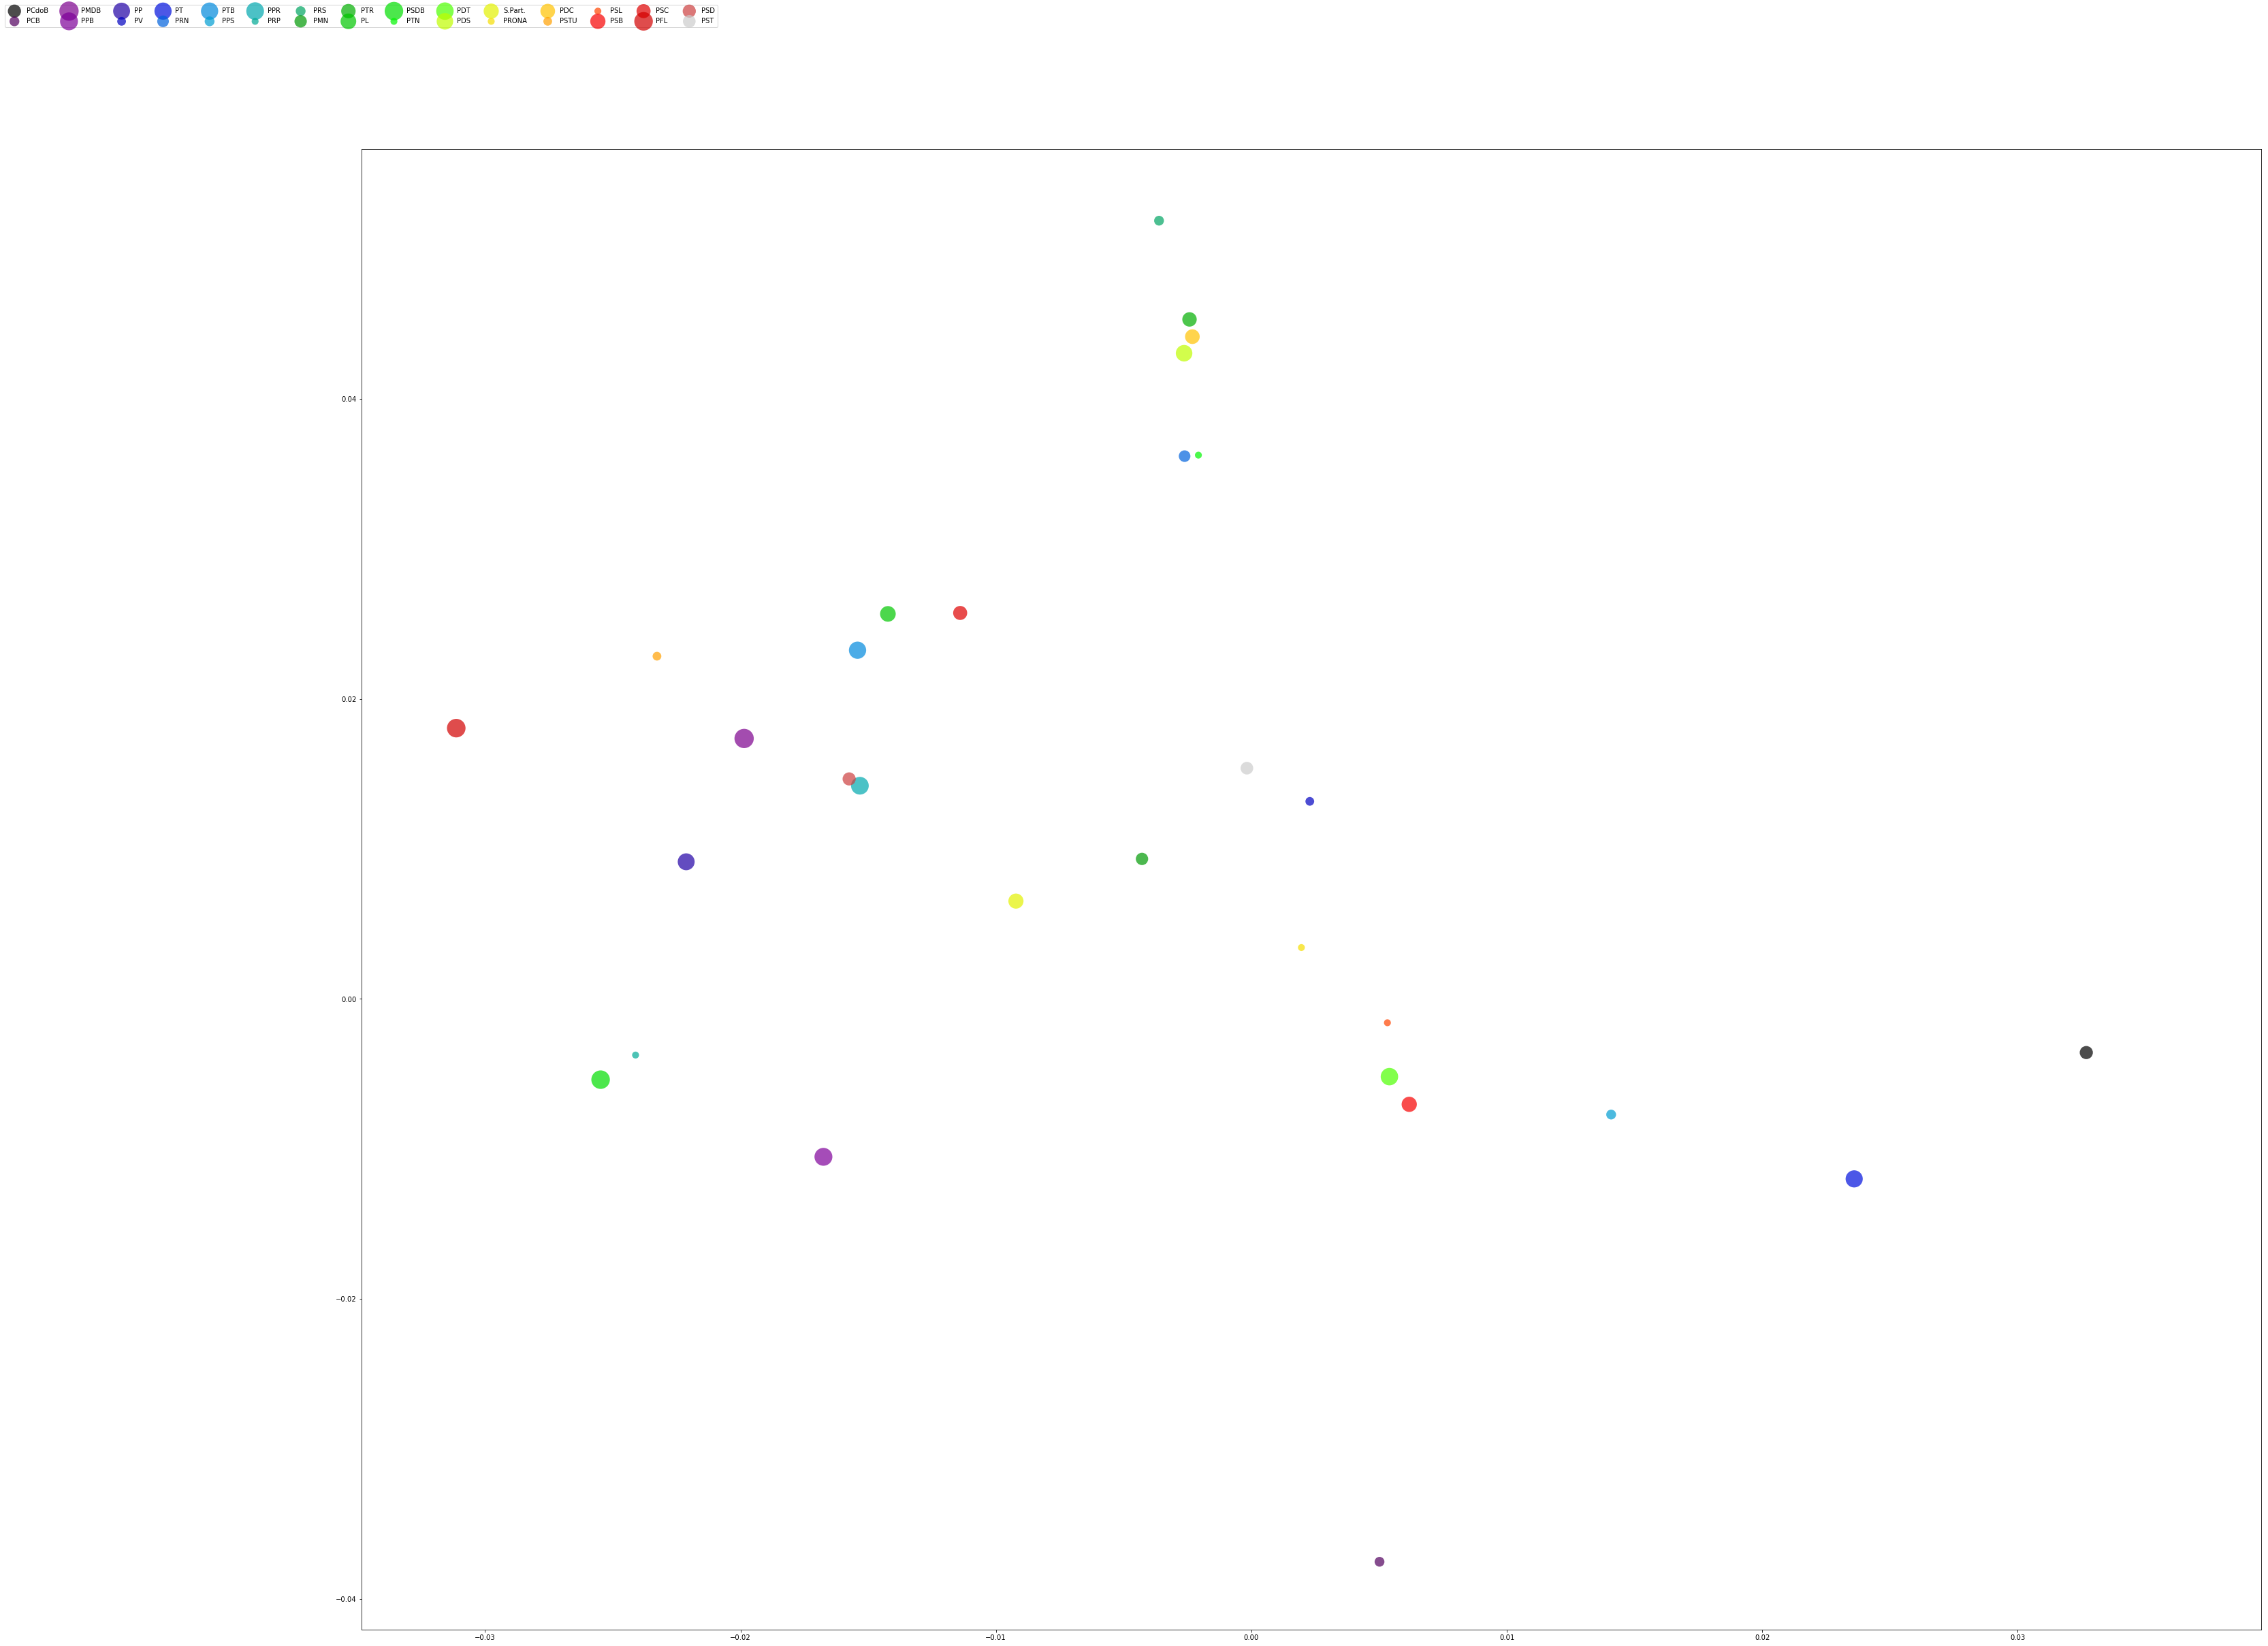

In [25]:
rgb_values = plt.get_cmap("nipy_spectral", len(cj_partidos))
colors = [rgb_values(i) for i in range(len(cj_partidos))]
cmap = dict(zip(cj_partidos,colors))
counts = Counter(partidos)

fig, ax = plt.subplots(figsize=(50,40))
for p in cj_partidos:
    pts = partidos[partidos==p].index
    ax.scatter(np.mean(U[pts,0]),np.mean(U[pts,1]), c=cmap[p], s = np.log(counts[p]+1)*150, label=p,
               alpha=0.7, edgecolors='none')

ax.legend(loc=9,ncol=(len(cj_partidos)+1)//2,bbox_to_anchor=(0, 1.1))
plt.show()

## Análise de regiões

In [26]:
reg_ord = np.lexsort([iafinidade,regioes])
corr_regiao = corr[reg_ord,:]
corr_regiao = corr_regiao[:,reg_ord]

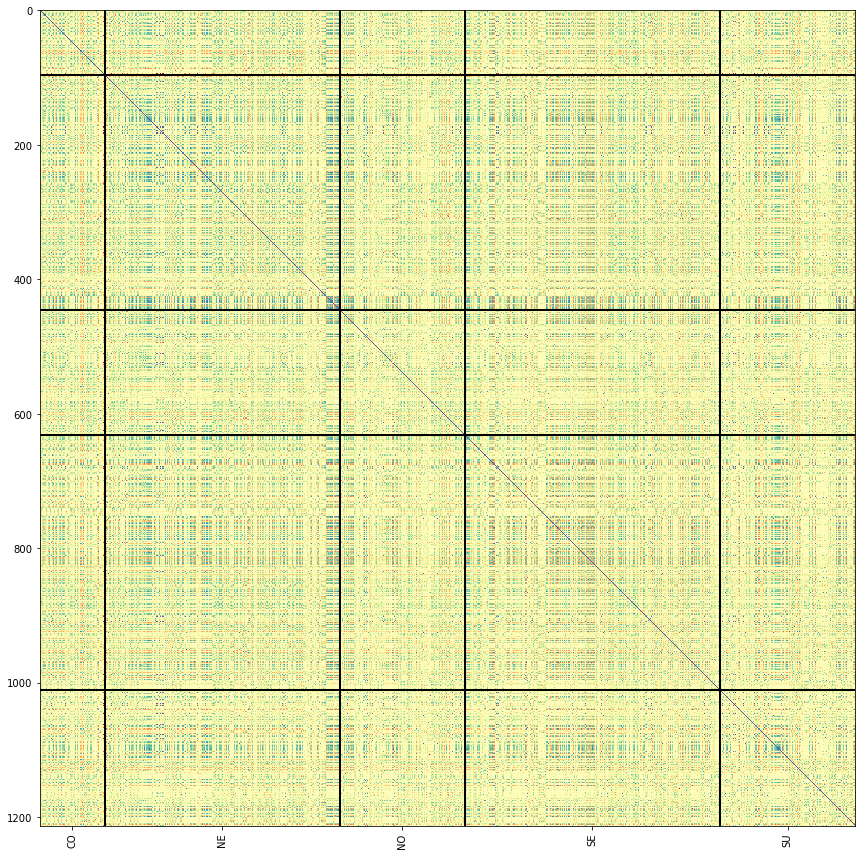

In [27]:
fig,ax = plt.subplots(figsize=(20,15))
regioes_ord = pd.Series(regioes[reg_ord].reset_index(drop=True))
splits = [i for i in range(len(regioes_ord)-1) if regioes_ord[i] != regioes_ord[i+1]]
cj_regioes = set(regioes_ord) 
pos = [np.mean(np.where(regioes_ord==p))  for p in cj_regioes]

ax.imshow(corr_regiao,cmap=plt.get_cmap('Spectral'))
for i in splits:
    ax.plot([0,votos.shape[0]-1],[i+0.5,i+0.5],color='black',lw=2)
    ax.plot([i+0.5,i+0.5],[0,votos.shape[0]-1],color='black',lw=2)
    
ax.set_xticks(pos)
#ax.set_yticks(range(len(deputados)))
ax.set_xticklabels(cj_regioes,rotation=90)
#ax.set_yticklabels(deputados[reg_ord])
plt.show()

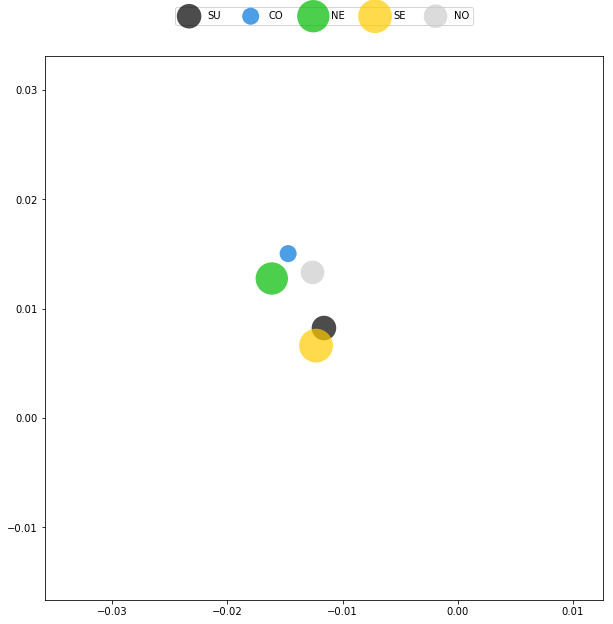

In [ ]:
rgb_values = plt.get_cmap("nipy_spectral", len(cj_regioes))
colors = [rgb_values(i) for i in range(len(cj_regioes))]
cmap = dict(zip(cj_regioes,colors))
counts = Counter(regioes)

fig, ax = plt.subplots(figsize=(10,10))
for p in cj_regioes:
    pts = regioes[regioes==p].index
    ax.scatter(np.mean(U[pts,0]),np.mean(U[pts,1]), c=cmap[p], s = counts[p]*3, label=p,
               alpha=0.7, edgecolors='none')

ax.legend(loc=9,ncol=(len(cj_partidos)+1)//2,bbox_to_anchor=(0.5, 1.1))
plt.show()

## Previsão de votação

In [ ]:
acertos = []
por_partido = {
    'PT' : [],
    'PMDB' : [],
    'PSDB' : [],
}
for votacao in range(1,votos.shape[1]):
    d = squareform(pdist(votos.iloc[:,range(votacao)]))
    np.fill_diagonal(d,float('inf'))
    nn = [np.random.choice(np.argwhere(d[i,:] == np.amin(d[i,:]))[0]) for i in range(len(d))] 
    prediction = votos.iloc[nn,votacao].reset_index(drop=True)
    acertos.append(np.mean(prediction == votos.iloc[:,votacao]))
    for p in por_partido.keys():
        sset = np.where(partidos==p)[0]
        por_partido[p].append(np.mean(prediction.iloc[sset] == votos.iloc[sset,votacao]))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(acertos,label="Geral")
for p in por_partido.keys():
    ax.plot(por_partido[p],label=p,alpha=0.5)
ax.legend(loc=9,ncol=4,bbox_to_anchor=(0.5, 1.03))
plt.show()